In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('heart.csv')

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.shape

(918, 12)

In [5]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# Data Preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Dictionary to store mappings
encodings = {}

# Label encode categorical features
for column in ['Sex', 'ChestPainType', 'ExerciseAngina', 'RestingECG', 'ST_Slope']:
    data[column] = label_encoder.fit_transform(data[column])
    # Store the mappings
    encodings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Verify the encoding mappings
for column, mapping in encodings.items():
    print(f"Encoding for {column}: {mapping}")

# Check the transformed data
print(data.head())


Encoding for Sex: {'F': 0, 'M': 1}
Encoding for ChestPainType: {'ASY': 0, 'ATA': 1, 'NAP': 2, 'TA': 3}
Encoding for ExerciseAngina: {'N': 0, 'Y': 1}
Encoding for RestingECG: {'LVH': 0, 'Normal': 1, 'ST': 2}
Encoding for ST_Slope: {'Down': 0, 'Flat': 1, 'Up': 2}
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    1              1        140          289          0           1   
1   49    0              2        160          180          0           1   
2   37    1              1        130          283          0           2   
3   48    0              0        138          214          0           1   
4   54    1              2        150          195          0           1   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         2             0  
1    156               0      1.0         1             1  
2     98               0      0.0         2             0  
3    108               1      1.5  

In [9]:
# Separate features and target
X = data.drop(columns=['HeartDisease'])
y = data['HeartDisease']

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Create pipelines for preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())                 # Standardize numerical features
])

# Combine pipelines into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', 'passthrough', categorical_features)  # Categorical features are already label-encoded
    ]
)

# Apply preprocessing to all features
X_preprocessed = preprocessor.fit_transform(X)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis (EDA)

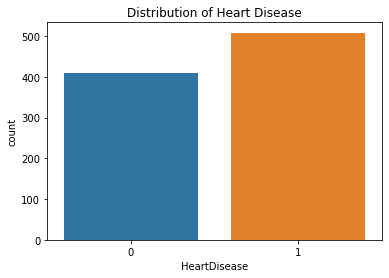

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Distribution of target variable (HeartDisease)
sns.countplot(x='HeartDisease', data=data)
plt.title('Distribution of Heart Disease')
plt.show()

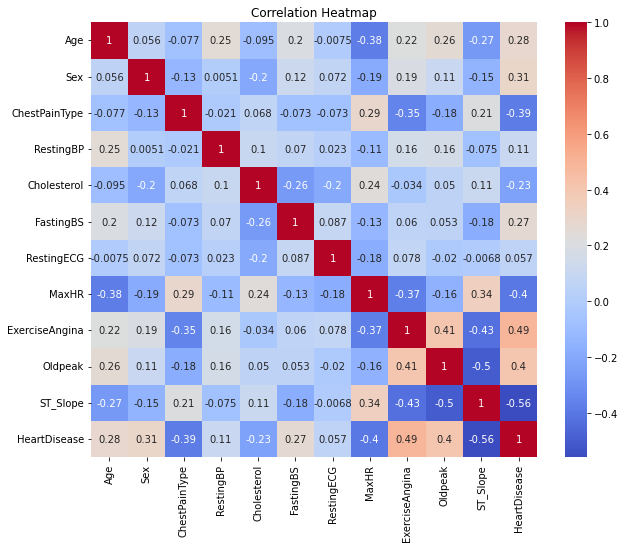

In [13]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

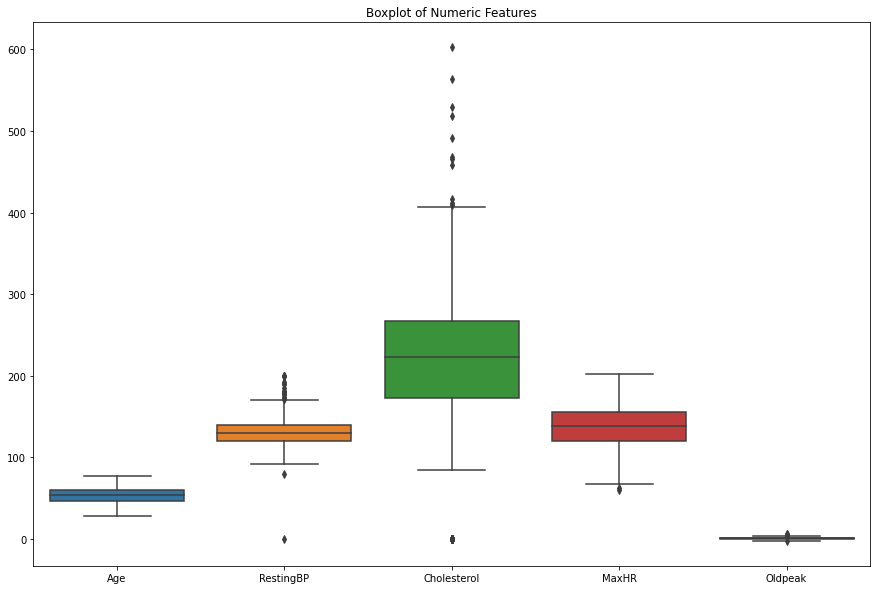

In [14]:
# Boxplot for numerical features
plt.figure(figsize=(15, 10))
sns.boxplot(data=data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])
plt.title('Boxplot of Numeric Features')
plt.show()

# Feature Optimization

In [15]:
# Apply SelectKBest
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import f1_score

f1_scores = []

# Try different values of k (number of features) to identify the optimal number
for k in range(1, X_train.shape[1] + 1):
    # Select top k features using mutual information
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # Train a basic logistic regression model for comparison
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    model.fit(X_train_selected, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test_selected)

    # Calculate weighted F1-score
    score = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(score)

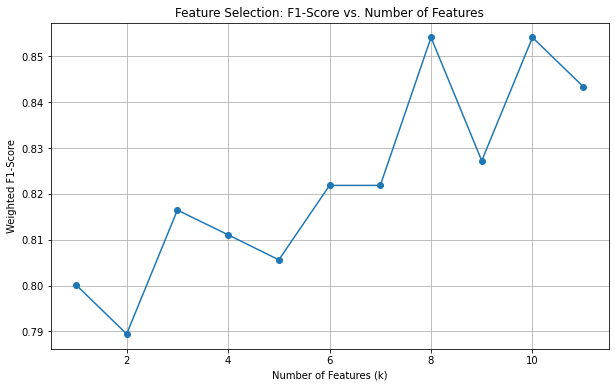

Optimal number of features: 8


In [16]:
# Plot F1-Score vs. Number of Features
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_train.shape[1] + 1), f1_scores, marker='o')
plt.title("Feature Selection: F1-Score vs. Number of Features")
plt.xlabel("Number of Features (k)")
plt.ylabel("Weighted F1-Score")
plt.grid(True)
plt.show()

# Find the best k based on maximum F1-score
optimal_k = f1_scores.index(max(f1_scores)) + 1
print(f"Optimal number of features: {optimal_k}")

In [17]:
# Apply SelectKBest with the optimal number of features
selector = SelectKBest(mutual_info_classif, k=optimal_k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Retrieve selected feature names
selected_feature_names = []
selected_feature_names.extend(
    [numeric_features[i] for i, selected in enumerate(selector.get_support()[:len(numeric_features)]) if selected]
)
selected_feature_names.extend(
    [categorical_features[i] for i, selected in enumerate(selector.get_support()[len(numeric_features):]) if selected]
)

print("Selected Features:", selected_feature_names)

Selected Features: ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope']


In [18]:
# Rebuild ColumnTransformer with selected features
updated_preprocessor = ColumnTransformer([
    ('num', numeric_transformer, [f for f in numeric_features if f in selected_feature_names]),
    ('cat', 'passthrough', [f for f in categorical_features if f in selected_feature_names])
])

# Preprocess the data again using the updated transformer
X_final = updated_preprocessor.fit_transform(X)

# Perform a new train-test split with the reduced features
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Display shapes of updated datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (734, 8)
X_test shape: (184, 8)


# Building the Deep Learning Model (FCN)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

def create_model(input_dim):
    model = Sequential([
        Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Train and Evaluate the Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model
model = create_model(X_train.shape[1])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])



Epoch 1/100
23/23 [==============================] - 1s 15ms/step - loss: 1.2161 - accuracy: 0.5559 - val_loss: 1.0922 - val_accuracy: 0.7663
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 1.0209 - accuracy: 0.7425 - val_loss: 0.9504 - val_accuracy: 0.7880
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.9123 - accuracy: 0.7834 - val_loss: 0.8597 - val_accuracy: 0.8098
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.8198 - accuracy: 0.8215 - val_loss: 0.7977 - val_accuracy: 0.8152
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.7540 - accuracy: 0.8256 - val_loss: 0.7503 - val_accuracy: 0.8098
Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7160 - accuracy: 0.8311 - val_loss: 0.7071 - val_accuracy: 0.8098
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.8365 - val_loss: 0.6758 - val_accuracy: 0.8152
Epoch 8/100


In [21]:
# Evaluate on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

6/6 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8424
Test Loss: 0.4351
Test Accuracy: 0.8424


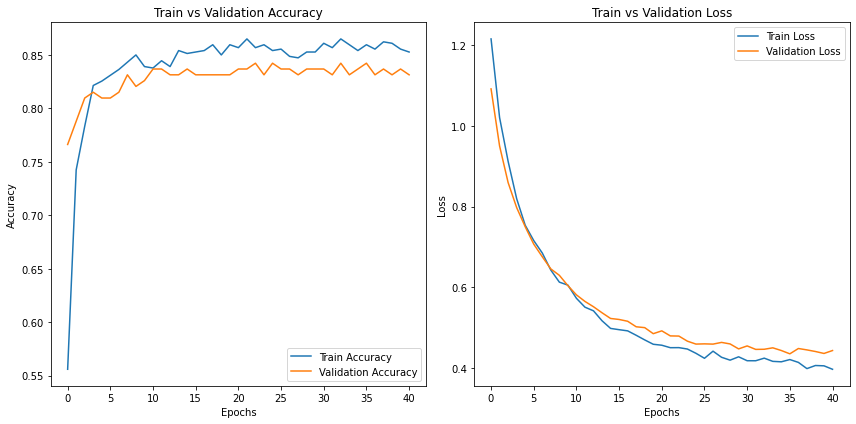

In [22]:
# Plot learning curves
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Hyperparameter Tuning

In [23]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def hyperparameter_model(optimizer='adam', units=64, dropout_rate=0.0):
    model = Sequential([
        Dense(units=units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(units=units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap with KerasClassifier
model = KerasClassifier(build_fn=hyperparameter_model, verbose=0)

# Define hyperparameter grid
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.5],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10, 20],
    'batch_size': [16, 32]
}

# GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_result = grid.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_result.best_score_}")


C:\Users\rishi\AppData\Local\Temp\ipykernel_13232\4100799326.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=hyperparameter_model, verbose=0)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
8/8 [==============================] - 0s 2ms/step
Best Parameters: {'batch_size': 16, 'dropout_rate': 0.0, 'epochs': 20, 'optimizer': 'adam', 'units': 64}
Best Cross-Validation Accuracy: 0.8610293297646928


# Train the Final Model with Best Hyperparameters

In [24]:
# Train final model with optimal hyperparameters
final_model = hyperparameter_model(
    optimizer=grid_result.best_params_['optimizer'],
    units=grid_result.best_params_['units'],
    dropout_rate=grid_result.best_params_['dropout_rate']
)

# Train final model with optimal parameters
history = final_model.fit(X_train, y_train, epochs=grid_result.best_params_['epochs'],
                          batch_size=grid_result.best_params_['batch_size'], validation_data=(X_test, y_test))

Epoch 1/20
46/46 [==============================] - 1s 7ms/step - loss: 0.5172 - accuracy: 0.7629 - val_loss: 0.4609 - val_accuracy: 0.7772
Epoch 2/20
46/46 [==============================] - 0s 3ms/step - loss: 0.3846 - accuracy: 0.8542 - val_loss: 0.4258 - val_accuracy: 0.7935
Epoch 3/20
46/46 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.8651 - val_loss: 0.3965 - val_accuracy: 0.8207
Epoch 4/20
46/46 [==============================] - 0s 3ms/step - loss: 0.3474 - accuracy: 0.8678 - val_loss: 0.4096 - val_accuracy: 0.8152
Epoch 5/20
46/46 [==============================] - 0s 3ms/step - loss: 0.3475 - accuracy: 0.8583 - val_loss: 0.4033 - val_accuracy: 0.8207
Epoch 6/20
46/46 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.8610 - val_loss: 0.3772 - val_accuracy: 0.8261
Epoch 7/20
46/46 [==============================] - 0s 4ms/step - loss: 0.3257 - accuracy: 0.8624 - val_loss: 0.3607 - val_accuracy: 0.8478
Epoch 8/20
46/46 [==

In [25]:
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)  

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

6/6 [==============================] - 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184


Confusion Matrix:
[[68  9]
 [15 92]]


In [26]:
# Final Test Evaluation
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

6/6 [==============================] - 0s 3ms/step - loss: 0.3245 - accuracy: 0.8696
Final Test Loss: 0.3245
Final Test Accuracy: 0.8696


# Save and Load the Model

In [27]:
final_model.save('heart_attack.h5')

In [28]:
import joblib
# Save preprocessor and selector
joblib.dump(updated_preprocessor, 'updated_preprocessing_pipeline.pkl')
joblib.dump(selector, 'feature_selector.pkl')

['feature_selector.pkl']

In [29]:
import json

# Assuming selected_feature_names is already a list
columns = {'data_columns': selected_feature_names}

# Save to columns.json
with open("columns.json", "w") as f:
    json.dump(columns, f)


# Load and Test the Model

In [30]:
# Load the saved model and preprocessing pipeline
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('heart_attack.h5')

# Load preprocessing pipeline
loaded_preprocessor = joblib.load('updated_preprocessing_pipeline.pkl')
loaded_selector = joblib.load('feature_selector.pkl')

# Test the loaded model on the test data
loaded_model_loss, loaded_model_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Loaded Model Test Accuracy: {loaded_model_accuracy:.4f}")


6/6 [==============================] - 0s 4ms/step - loss: 0.3245 - accuracy: 0.8696
Loaded Model Test Accuracy: 0.8696
